In [1]:
import tensorflow as tf
import os 
import json
import pandas as pd
import nltk
import numpy as np
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from random import randint
from tensorflow.python.layers.core import Dense



/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
tf.__version__

'1.6.0'

In [4]:
file_path = os.getcwd()+"/idebate.json"
Glove_path=os.getcwd()+"/glove.6B.50d.txt"

def load_data(file_path):
    with open(file_path) as file:
        raw_data=file.read()
        json_data=json.loads(raw_data)
    dataframe=pd.DataFrame(columns=["text","summary"])
    for i in json_data:
        text_summary_pair={}
        text=" "
        for x in i["_argument_sentences"]:
            text=text+i["_argument_sentences"][x].lower()
            #probably we can get rid of stopping word and punctuaton for input
        text_summary_pair["text"]=text
        text_summary_pair["summary"]=i["_claim"]
        dataframe=dataframe.append(text_summary_pair,ignore_index=True)#append doesn't happen in place
    return dataframe
##########################################
dataframe=load_data(file_path)

In [5]:
#split data
#60% training, 20%testing 20%evaluation
def data_split(dataframe):
    train_dataframe,testandvalidation_dataframe=train_test_split(dataframe,test_size=0.4)
    test_dataframe,evaluation_dataframe=train_test_split(testandvalidation_dataframe,test_size=0.5)
    return train_dataframe,test_dataframe, evaluation_dataframe
########################################## 
train_dataframe,test_dataframe, evaluation_dataframe=data_split(dataframe)

In [6]:
train_dataframe.head()

,text,summary
29,"1999 .trade , income disparity and poverty .d...",Free trade is good for development and growth.
1213,such a ban would be limited such as being onl...,There is precedent for putting restrictions on...
1926,so for example if mississippi and new mexico ...,Being a federal state helps large states deal ...
736,"wwf , african rhino poaching crisis zapwing ,...",Poaching is becoming more advanced
1342,a major problem with this policy is that it p...,Gives power to military coup leaders


In [7]:
print(dataframe["text"][1])

 there may be the possibility of winning a big prize , but the overwhelming likelihood is that a gambler will lose money .instead , governments should be promoting values like thrift , hard work and self-reliance rather than encouraging or even allowing gambling to promote its own negative values .those in society who most need to self-improve , never do .instead , they tie their hopes and dreams to the lottery .it also sends out the message that success should not necessarily be the result of merit and effort .as a philosophy , gambling culture is incredibly dangerous .gambling makes people concentrate of winning money .religious leaders of all denominations see gambling as eroding family values because it implies that material goods should be valued above other things like friendships and families .


In [8]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
##################################################
word_vec=loadGloveModel(Glove_path)

Loading Glove Model
Done. 400000  words loaded!


In [9]:
#add <GO>,<EOS>,<PAD> to the list

In [10]:
#return word_list and vector_list
words_list=[]
vectors_list=[]
for i in word_vec:
    words_list.append(i)
    vectors_list.append(word_vec[i])
    
GO_vector=[1]*50
EOS_vector=[2]*50
PAD_vector=[0]*50
words_list.append("<GO>")
vectors_list.append(GO_vector)
words_list.append("<EOS>")
vectors_list.append(EOS_vector)

words_list.insert(0,"<PAD>")
vectors_list.insert(0,PAD_vector)
vectors_array=np.array([np.array(xi) for xi in vectors_list])
Vectors_array=tf.constant(vectors_array, name="vectors_array")


In [11]:
len(vectors_list)

400003

In [12]:
sum_len=[]
text_len=[]
max_text_len=0
max_sum_len=0
for i in dataframe["text"]:
    text_len.append(len(i.split()))
    if len(i.split())>max_text_len:
        max_text_len=len(i.split())
        

for i in dataframe["summary"]:
    sum_len.append(len(i.split()))
    if len(i.split())>max_sum_len:
        max_sum_len=len(i.split())
    
    

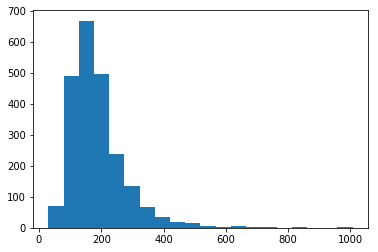

In [13]:
plt.hist(text_len,20)
plt.show()

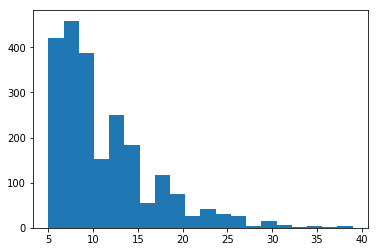

In [14]:
plt.hist(sum_len,20)
plt.show()

In [15]:
maxtextlength=400
maxsumlength=25


In [16]:
def text2ids(dataframe):
    numfiles=dataframe.shape[0]
    text_ids=[]
    #np.zeros((numfiles, maxtextlength), dtype='int32')
    for text in dataframe["text"]:
        sentence_ids=[]
        text_word_list=text.split()
        for word in text_word_list:
            try:
                word_index=words_list.index(word)
            except ValueError:
                word_index=words_list.index("unk")
            sentence_ids.append(word_index)
        text_ids.append(sentence_ids)
    return text_ids

test_text_ids=text2ids(test_dataframe)
print("test_dataframe finished" )
train_text_ids=text2ids(train_dataframe)
print("train_dataframe finished" )
evaluation_text_ids=text2ids(evaluation_dataframe)
print("evaluation_dataframe finished" )

test_dataframe finished
train_dataframe finished
evaluation_dataframe finished


In [20]:
def summary2ids(dataframe):
    summary_ids = []
    for summary in dataframe["summary"]:
        summary_word_list=summary.split()
        summary_word_list.append("<EOS>")
        sentence_ids=[]
        for word in summary_word_list:
            try:
                word_index=words_list.index(word)
            except ValueError:
                word_index=words_list.index("unk")
            sentence_ids.append(word_index)
            
        summary_ids.append(sentence_ids)
    return summary_ids
#################################################
test_summary_ids=summary2ids(test_dataframe)
print("test_dataframe finished")
train_summary_ids=summary2ids(train_dataframe)
print("train_dataframe finished")
evaluation_summary_ids=summary2ids(evaluation_dataframe) 
print("evalution_dataframe finished")

test_dataframe finished
train_dataframe finished
evalution_dataframe finished


# Build model


In [77]:
#encoding_dim
#batchsize


#text_input_data
#enc_rnn_node //how many node for a single layer
#num_layers //how many layers are there
#text_sequence_length //
#encoding_embedding_dim //50 for example
def get_encoder_layer(batch_size,
                      text_input_data,
                      enc_rnn_node, 
                       num_layers,
                      text_sequence_length,
                      encoding_dim):
    
   
    #encoder_embed_input = tf.contrib.layers.embed_sequence(input_data, source_vocab_size, encoding_embedding_size)
    embedding_data = tf.Variable(tf.zeros([batch_size, maxtextlength, encoding_dim]),dtype=tf.float32)
    embedding_data = tf.nn.embedding_lookup(Vectors_Array,text_input_data)  #final input for encoder
    embedding_data=tf.cast(embedding_data,tf.float32)

    # a single RNN cell
    def get_lstm_cell(enc_rnn_node):
        lstm_cell = tf.contrib.rnn.LSTMCell(enc_rnn_node, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return lstm_cell
    
    #cell here stands for a Rnn single layer
    cell = tf.contrib.rnn.MultiRNNCell([get_lstm_cell(enc_rnn_node) for _ in range(num_layers)])   #why not use concatenate function??????
    encoder_output, encoder_state = tf.nn.dynamic_rnn(cell, 
                                                      embedding_data,
                                                      sequence_length=text_sequence_length, 
                                                      dtype=tf.float32)
    return encoder_output, encoder_state



In [94]:
def decoding_layer(batch_size,
                   sum_input_data,
                   dec_rnn_node,
                   num_layers,
                   sum_sequence_length,
                   vocab_size,
                   encoding_dim,
                   encoder_state,
                   go_index,
                   eos_index,
                   max_sum_sequence_length):

    def process_decoder_input(sum_input_data, batch_size,go_index):
        
        # cut掉最后一个字符
        #endding is the input which already get rid of the endding
        ending = tf.strided_slice(sum_input_data, [0, 0], [batch_size, -1], [1, 1])
        processed_decoder_input = tf.concat([tf.fill([batch_size, 1], go_index), ending], 1)
        return processed_decoder_input
    
    processed_sum_input_data=process_decoder_input(sum_input_data,batch_size,go_index)
    
    # 1. Embedding
    
    
    #target_vocab_size = len(100000)  #total 
    #decoder_embeddings = tf.Variable(tf.random_uniform([400003, 50]))
    #decoder_embed_input = tf.nn.embedding_lookup(decoder_embeddings,processed_sum_input_data )
    #Vectors_Array = tf.Variable(tf.constant(0.0, shape=[400003, 50]), trainable=False, name="vectors_array")
    
    #decoder_embedding_data = tf.Variable(tf.zeros([batch_size, maxsumlength, encoding_dim]),dtype=tf.float32)
    decoder_embedding_data = tf.nn.embedding_lookup(Vectors_Array,processed_sum_input_data)  #final input for decoder 
    decoder_embedding_data=tf.cast(decoder_embedding_data,tf.float32) 
    
    # 2. 构造Decoder中的RNN单元
    def get_decoder_cell(dec_rnn_node):
        print("so far so good?")
        decoder_cell = tf.contrib.rnn.LSTMCell(dec_rnn_node,
                                               initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))  #initialize what????????????
        print("so far so good!")
        return decoder_cell
    
    
    
    cell = tf.contrib.rnn.MultiRNNCell([get_decoder_cell(dec_rnn_node) for _ in range(num_layers)])
     

    output_layer = Dense(vocab_size,kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))


    # 4. Training decoder
    with tf.variable_scope("decode"):
        # 得到help对象
        training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=decoder_embedding_data,
                                                            sequence_length=sum_sequence_length,
                                             
                                                            time_major=False) #what is time major
        # 构造decoder
        training_decoder = tf.contrib.seq2seq.BasicDecoder(cell,
                                                           training_helper,
                                                           encoder_state,
                                                           output_layer) 
        
        training_decoder_output,_ ,_= tf.contrib.seq2seq.dynamic_decode(training_decoder,impute_finished=True,maximum_iterations=max_sum_sequence_length)
        print("training decoder is built")                                                       
    # 5. Predicting decoder
    # 与training共享参数
    
    #multiply = tf.constant([3])
    with tf.variable_scope("decode", reuse=True):
        start_tokens = tf.tile([tf.constant((go_index), dtype=tf.int32)],
                               [tf.constant(batch_size)], 
                               name='start_tokens')
        
        predicting_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(Vectors_Array,start_tokens,eos_index)
        
        predicting_decoder = tf.contrib.seq2seq.BasicDecoder(cell,
                                                             predicting_helper,
                                                             encoder_state,
                                                             output_layer)
        print("predicting decoder is build")
        
        predicting_decoder_output, _,_ = tf.contrib.seq2seq.dynamic_decode(predicting_decoder,impute_finished=True,maximum_iterations=max_sum_sequence_length)#,
                                                                         #maximum_iterations=max_sum_sequence_length)
    return training_decoder_output, predicting_decoder_output



In [95]:
def seq2seq_model(batch_size,
                  text_input_data,
                  sum_input_data,
                  sum_sequence_length,
                  max_sum_sequence_length, 
                  text_sequence_length,
                  vocab_size,
                  encoding_dim,  
                  enc_rnn_node,
                  dec_rnn_node,
                  num_layers,
                  vectors_array,
                  go_index,
                  eos_index):
    # 获取encoder的状态输出
    _, encoder_state = get_encoder_layer(batch_size,
                                         text_input_data,
                                         enc_rnn_node,
                                         num_layers,
                                         text_sequence_length,
                                         encoding_dim)
    
    
    
    # 将状态向量与输入传递给decoder
    training_decoder_output, predicting_decoder_output = decoding_layer(batch_size,
                                                                        sum_input_data,
                                                                        dec_rnn_node,
                                                                        num_layers,
                                                                        sum_sequence_length,
                                                                        vocab_size,
                                                                        encoding_dim,
                                                                        encoder_state,
                                                                        go_index,
                                                                        eos_index,
                                                                        max_sum_sequence_length) 
    
    return training_decoder_output, predicting_decoder_output

In [104]:
epochs = 60
batch_size = 100
enc_rnn_node = 400
dec_rnn_node=400
num_layers = 2
Learning_Rate = 0.1
vocab_size=len(words_list)
go_index=words_list.index("<GO>")
eos_index=words_list.index("<EOS>")
pad_index=words_list.index("<PAD>")
encoding_dim=50

In [105]:
vectors_array.shape

(400003, 50)

In [106]:
train_graph = tf.Graph()
with train_graph.as_default():
    Vectors_Array = tf.Variable(tf.constant(0.0, shape=[400003, 50]), trainable=False, name="vectors_array")
    embedding_placeholder = tf.placeholder(tf.float32, [400003, 50])
    embedding_init = Vectors_Array.assign(embedding_placeholder)
    text_input_data = tf.placeholder(tf.int32, [None, None], name='text_input_data')
    sum_input_data = tf.placeholder(tf.int32, [None, None], name='sum_input_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    sum_sequence_length = tf.placeholder(tf.int32, (None,), name='sum_sequence_length')
    max_sum_sequence_length = tf.reduce_max(sum_sequence_length, name='max_sum_len')
    text_sequence_length = tf.placeholder(tf.int32, (None,), name='text_sequence_length')
    print("A")
    
    training_decoder_output, predicting_decoder_output = seq2seq_model(batch_size,
                                                                       text_input_data,
                                                                       sum_input_data,
                                                                       sum_sequence_length,
                                                                       max_sum_sequence_length,
                                                                       text_sequence_length,
                                                                       vocab_size,
                                                                       encoding_dim,
                                                                       enc_rnn_node,
                                                                       dec_rnn_node,
                                                                       num_layers,
                                                                       Vectors_Array,
                                                                       go_index,
                                                                       eos_index) 
    print("B")
    
    training_logits = tf.identity(training_decoder_output.rnn_output, name='logits')   
    print("C")
    predicting_logits = tf.identity(predicting_decoder_output.sample_id, name='predictions')
    print("D")
    masks = tf.sequence_mask(sum_sequence_length, max_sum_sequence_length, dtype=tf.float32, name='masks')
    
    print("E")

    with tf.name_scope("optimization"):
        
        # Loss function
        #crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=decoder_outputs, logits=logits)
        #train_loss = (tf.reduce_sum(crossent * target_weights) /batch_size)
        cost = tf.contrib.seq2seq.sequence_loss(training_logits,sum_input_data,masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

A
so far so good?
so far so good!
so far so good?
so far so good!
training decoder is built
predicting decoder is build
B
C
D
E


In [107]:
sum_input_data

<tf.Tensor 'sum_input_data:0' shape=(?, ?) dtype=int32>

In [108]:
def padding(Inputs,batch_size,pad_index):
    padded_inputs=[]
    length_list=[]
    for Input in Inputs:
        if len(Input)>=400:
            padded_input=Input[:400]
            length=len(padded_input)
        else:
            length=len(Input)
            #padded_input=Input.extend([0]*(400-length))
            padded_input=np.pad(Input,(0,400-length),"constant",constant_values=0)
        length_list.append(length)
        padded_input=np.asarray(padded_input)
        padded_inputs.append(padded_input)
    padded_inputs=np.asarray(padded_inputs) 
    return padded_inputs,length_list

In [109]:
def get_valid_batches(text_ids,summary_ids, batch_size,pad_index):
    batch_i=randint(0, len(text_ids)//batch_size)
    start_i = batch_i * batch_size
    text_batch = text_ids[start_i:start_i + batch_size]
    summary_batch = summary_ids[start_i:start_i + batch_size]
    pad_text_batch,text_sequence_length = padding(text_batch,batch_size,pad_index)
    pad_summary_batch,sum_sequence_length = padding(summary_batch,batch_size,pad_index)
    return pad_text_batch, pad_summary_batch, text_sequence_length,sum_sequence_length

In [110]:
def get_batches(text_ids,summary_ids, batch_size,pad_index):
    for batch_i in range(0, len(text_ids)//batch_size):
        start_i = batch_i * batch_size
        text_batch = text_ids[start_i:start_i + batch_size]
        summary_batch = summary_ids[start_i:start_i + batch_size]
        pad_text_batch,text_sequence_length = padding(text_batch,batch_size,pad_index)
        pad_summary_batch,sum_sequence_length = padding(summary_batch,batch_size,pad_index)
        yield pad_text_batch, pad_summary_batch, text_sequence_length,sum_sequence_length

In [111]:
display_step = 2
checkpoint = "trained_model.ckpt" 
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(embedding_init, feed_dict={embedding_placeholder: vectors_array})
    for epoch_i in range(1, epochs+1):
        for batch_i, (train_text_batch, train_summary_batch, Text_Sequence_Length,Sum_Sequence_Length) in enumerate(
            get_batches(train_text_ids, train_summary_ids, batch_size,pad_index)):
            
            _, loss = sess.run(
                [train_op, cost],
                {text_input_data:train_text_batch,
                 sum_input_data: train_summary_batch,
                 learning_rate: Learning_Rate,
                 text_sequence_length:Text_Sequence_Length,
                 sum_sequence_length:Sum_Sequence_Length})

            if batch_i % display_step == 0:
                valid_text_batch,valid_summary_batch,valid_text_length,valid_summary_length=get_valid_batches()
                
                # 计算validation loss
                validation_loss = sess.run(
                [cost],
                {text_input_data: valid_text_batch,
                 summary_input_data: valid_summary_batch,
                 learning_rate: Learning_Rate,
                 text_sequence_length: valid_text_length,
                 sum_sequence_length: valid_summary_length})
                
                print('Epoch {:>3}/{} Batch {:>4}/{} - Training Loss: {:>6.3f}  - Validation loss: {:>6.3f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(train_text_ids) // batch_size, 
                              loss, 
                              validation_loss[0]))

    
    
    saver = tf.train.Saver()
    saver.save(sess, checkpoint)
    print('Model Trained and Saved')

InvalidArgumentError: logits and labels must have the same first dimension, got logits shape [3900,400003] and labels shape [40000]
	 [[Node: optimization/sequence_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](optimization/sequence_loss/Reshape, optimization/sequence_loss/Reshape_1)]]

Caused by op 'optimization/sequence_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-106-dfc80fd16352>", line 43, in <module>
    cost = tf.contrib.seq2seq.sequence_loss(training_logits,sum_input_data,masks)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/contrib/seq2seq/python/ops/loss.py", line 92, in sequence_loss
    labels=targets, logits=logits_flat)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 2042, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 4753, in _sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must have the same first dimension, got logits shape [3900,400003] and labels shape [40000]
	 [[Node: optimization/sequence_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](optimization/sequence_loss/Reshape, optimization/sequence_loss/Reshape_1)]]


In [103]:
train_summary_batch.shape

(100, 400)

In [71]:
len(Text_Sequence_Length)

100

In [38]:
def get_valid_batches(text_ids,summary_ids, batch_size,pad_index):
    batch_i=randint(0, len(text_ids)//batch_size)
    start_i = batch_i * batch_size
    text_batch = text_ids[start_i:start_i + batch_size]
    summary_batch = summary_ids[start_i:start_i + batch_size]
    pad_text_batch,text_sequence_length = padding(text_batch,batch_size,pad_index)
    pad_summary_batch,sum_sequence_length = padding(summary_batch,batch_size,pad_index)
    return pad_text_batch, pad_summary_batch, text_sequence_length,sum_sequence_length

In [39]:
ptb, pmb, tsl,ssl=get_valid_batches(test_text_ids,test_summary_ids, batch_size,pad_index)

In [89]:
training_decoder_output.rnn_output

<tf.Tensor 'decode/decoder/transpose:0' shape=(100, ?, 400003) dtype=float32>

In [32]:
pad_text_batch,text_sequence_length = padding(text_batch,batch_size,pad_index)

In [87]:
training_decoder_output.rnn_output

<tf.Tensor 'decode/decoder/transpose:0' shape=(100, ?, 400003) dtype=float32>

In [76]:
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    sess.run([train_op, cost],{text_input_data:train_text_batch,sum_input_data: train_summary_batch,learning_rate: Learning_Rate,text_sequence_length:Text_Sequence_Length,sum_sequence_length:Sum_Sequence_Length})

InvalidArgumentError: logits and labels must have the same first dimension, got logits shape [3900,400003] and labels shape [40000]
	 [[Node: optimization/sequence_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](optimization/sequence_loss/Reshape, optimization/sequence_loss/Reshape_1)]]

Caused by op 'optimization/sequence_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-b5d682de0072>", line 45, in <module>
    masks)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/contrib/seq2seq/python/ops/loss.py", line 92, in sequence_loss
    labels=targets, logits=logits_flat)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 2042, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 4753, in _sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/Users/yutian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must have the same first dimension, got logits shape [3900,400003] and labels shape [40000]
	 [[Node: optimization/sequence_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](optimization/sequence_loss/Reshape, optimization/sequence_loss/Reshape_1)]]


### TEST PROGRAM